# Type B and Type C QPO toy dataset
**Instructions (by Abigail):** the data are in my gsoc18 repository. it's toy_TypeB_lightcurve.fits and toy_TypeC_lightcurve.fits. Note that I only used a subset of the total data I used for making the power spectra I already gave you, so plotting the average power spectrum of these data will look a little different. With this data you can make averaged cross spectra, take the amplitude, normalize it (leahy or frac, probably), log rebin (by 0.04 or so) and fit it! You'll find you'll need one or two lorentzians for the broadband noise components in addition to the QPO and the harmonic (and a  power law), even in the cross spectrum amplitudes. I think the slope of the power law should be around 0 for the cross spectra. See if you can take the average cross spectra amplitudes of one source in a few CoI and fit them simultaneously, even tying the Lorentzian center frequencies together (i.e., the QPO lorentzians have the same frequency in the 5 different avg cross spectra amplitudes you're fitting of the same source, and the same for the other lorentzian components).
This work that you're doing right now is important for both types of phase-resolved spectroscopy. For mine, it is necessary to fit the cross spectra to make the 'filter' (i.e. de-noising) to apply to the cross spectrum before taking the iFFT to get the energy-dependent cross-correlation function. For Adam Ingram's method, it is necessary to fit the power spectrum in each energy channel to determine the center and FWHM of the QPO and harmonic so that you can automatically re-bin the light curve, make the average cross spectrum, and get the complex and imaginary components (which he then uses in his equations to reconstruct the QPO waveform in each energy channel). You're doing a good job keeping up with this

## Loading dataset

In [1]:
import astropy
from astropy.table import Table
from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum, DynamicalPowerspectrum, Crossspectrum, AveragedCrossspectrum
from astropy.modeling import models, fitting
from stingray.modeling.scripts import fit_powerspectrum, fit_lorentzians
from scipy.stats import binned_statistic

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline

In [2]:
type_b = "./toy_TypeB_lightcurve.fits"
type_c = "./toy_TypeC_lightcurve.fits"

lc_fits = Table.read(type_b)
meta = lc_fits.meta
print(lc_fits.info())
print(meta)
dt = meta['DT']
n_bins = meta['N_BINS']
n_seg = meta['N_SEG']
n_seconds = meta['NSECONDS']
lc_fits

<Table length=8192>
name  dtype   shape   unit             description           
---- ------- ------- ------ ---------------------------------
 REF float64   (46,) ct / s       Reference band light curves
  CI float64 (5, 46) ct / s Channels of interest light curves
None
OrderedDict([('N_BINS', 8192), ('DT', 0.0078125), ('DETCHANS', 5), ('CHBIN', '/Users/abbie/Documents/GitHub/gsoc18/epoch5_chbinfile.txt'), ('N_SEG', 46), ('NSECONDS', 64.0), ('INFILE', "['st.fits']"), ('OBJECT', 'GX_339-4')])


REF [46],"CI [5,46]"
ct / s,ct / s
float64,float64
256.0 .. 768.0,256.0 .. 0.0
256.0 .. 384.0,256.0 .. 0.0
512.0 .. 640.0,256.0 .. 0.0
640.0 .. 128.0,384.0 .. 0.0
1408.0 .. 384.0,384.0 .. 0.0
768.0 .. 768.0,768.0 .. 128.0
256.0 .. 512.0,512.0 .. 256.0
512.0 .. 128.0,512.0 .. 256.0


In [3]:
# multiply dt to get counts
ref = np.asarray(lc_fits['REF'].T * dt, dtype=np.float64)
ci = np.asarray(lc_fits['CI'].T * dt, dtype=np.float64)
times = np.arange(0, n_seconds*n_seg, dt)
print(ref.shape, ci.shape, times.shape)

# get counts in ref and ci bands
ref_counts = np.hstack(ref)
ci_counts = np.hstack(ci)
print(ref_counts.shape, ci_counts.shape, times.shape)

(46, 8192) (46, 5, 8192) (376832,)
(376832,) (5, 376832) (376832,)


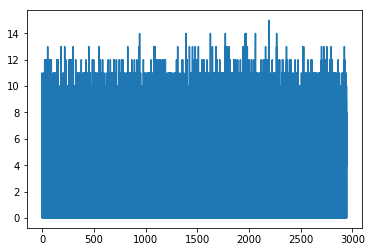

In [4]:
# taking all segments
counts = np.hstack(ref)
# print(times)
lc = Lightcurve(times, counts, dt=dt)
lc.plot()


1.5965150302943583


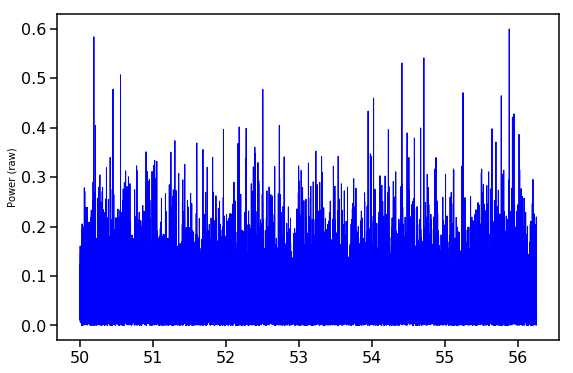

In [5]:
ps = Powerspectrum(lc, norm='abs')

# print(len(ps.freq))
# print(ps.freq)
# print(ps.power)
# print(ps.df)
# print(ps.m)
# print(ps.n)
# print(ps.nphots1)

print(max(ps.power))

fig, ax1 = plt.subplots(1,1,figsize=(9,6))
ax1.plot(ps.freq[int(800/1024*len(ps.freq)):int(900/1024*len(ps.freq))], ps.power[int(800/1024*len(ps.freq)):int(900/1024*len(ps.freq))], lw=1, color='blue')
ax1.set_ylabel("Frequency (Hz)")
ax1.set_ylabel("Power (raw)")
# ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()

## Cross spectrum and Averaged cross spectrum

In [6]:
times = np.arange(0, n_seconds*n_seg, dt)
lc1 = Lightcurve(times, ref_counts, dt=dt)
lc2 = Lightcurve(times, ci_counts[0], dt=dt)

In [7]:
cs1 = Crossspectrum(lc1=lc1, lc2=lc2, norm='leahy', amplitude=True)
cs1 = cs1.rebin_log(0.04) # rebinning

/Users/swapsha96/miniconda3/lib/python3.6/site-packages/stingray-0.1rc1-py3.6.egg/stingray/utils.py:89: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [8]:
avg_cs1 = AveragedCrossspectrum(lc1=lc1, lc2=lc2, segment_size=n_seg, norm='leahy')
avg_cs1 = avg_cs1.rebin_log(0.04) #rebinning

/Users/swapsha96/miniconda3/lib/python3.6/site-packages/stingray-0.1rc1-py3.6.egg/stingray/utils.py:89: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


<Figure size 432x288 with 0 Axes>

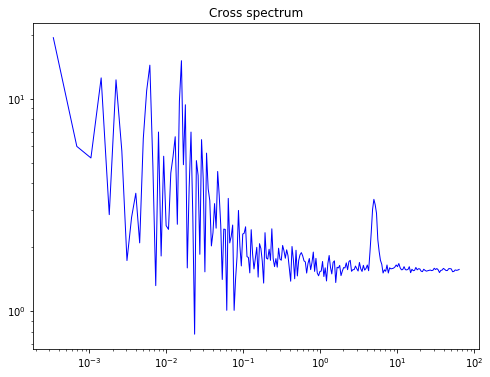

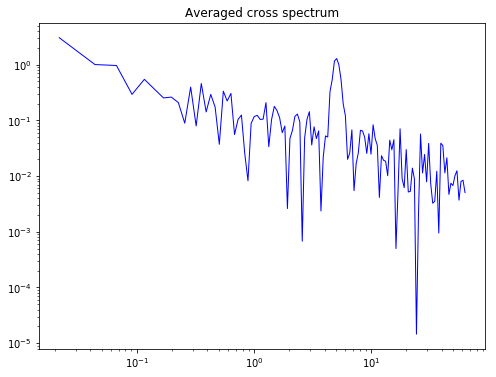

In [9]:
n = len(cs1.freq)
range_start, range_stop = int(0 * n / 64), int(64 * n / 64)

plt.tight_layout()
plt.subplots(0,0, figsize=(8,6))
plt.title("Cross spectrum")
plt.loglog(cs1.freq[range_start:range_stop], np.abs(cs1.power)[range_start:range_stop], lw=1, color='blue')

plt.subplots(1,1, figsize=(8,6))
plt.title("Averaged cross spectrum")
plt.loglog(avg_cs1.freq[range_start:range_stop], np.abs(avg_cs1.power)[range_start:range_stop], lw=1, color='blue')

In [10]:
from stingray.modeling import PSDLogLikelihood, PSDPosterior, PSDParEst, GaussianPosterior, GaussianLogLikelihood


def fit_crossspectrum(cs, model, starting_pars=None, max_post=False, priors=None,
                      fitmethod="L-BFGS-B"):
    """
    Fit a number of Lorentzian to a cross spectrum, possibly including white
    noise.
    """
    if not starting_pars:
        starting_pars = model.parameters
    if priors:
        lgauss = GaussianPosterior(cs.freq, np.abs(cs.power), model, priors=priors, yerr=cs.power_err)
    else:
        lgauss = GaussianLogLikelihood(cs.freq, np.abs(cs.power), model=model, yerr=cs.power_err)

    parest = PSDParEst(cs, fitmethod=fitmethod, max_post=max_post)
    res = parest.fit(lgauss, starting_pars, neg=True)

    return parest, res


## Fitting the model

Model: CompoundModel1
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Lorentz1D(amplitude=1., x_0=5., fwhm=1.)>

    [1]: <PowerLaw1D(amplitude=1., x_0=1., alpha=1.)>

    [2]: <Const1D(amplitude=2.)>
Parameters:
    amplitude_0 x_0_0 fwhm_0 amplitude_1 x_0_1 alpha_1 amplitude_2
    ----------- ----- ------ ----------- ----- ------- -----------
            1.0   5.0    1.0         1.0   1.0     1.0         2.0


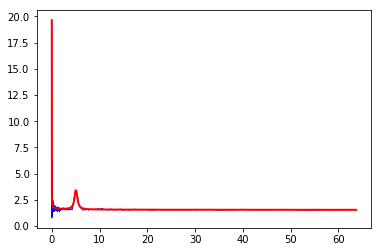

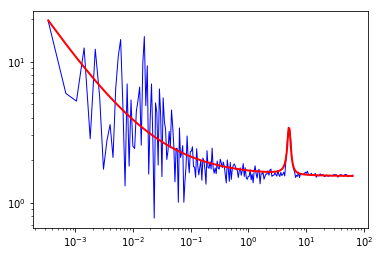

In [11]:
model_to_test = models.Lorentz1D(x_0=5.) + models.PowerLaw1D() + models.Const1D(amplitude=2)
print(model_to_test)

parest, res = fit_crossspectrum(cs1, model_to_test)

# plotting
n = len(cs1.freq)
range_start, range_stop = int(0 * n / 64), int(64 * n / 64)

plt.figure()
plt.plot(cs1.freq[range_start:range_stop], np.abs(cs1.power)[range_start:range_stop], lw=1, color='blue')
plt.plot(cs1.freq[range_start:range_stop], np.abs(res.mfit)[range_start:range_stop], lw=2, color="red")

plt.figure()
plt.loglog(cs1.freq[range_start:range_stop], np.abs(cs1.power)[range_start:range_stop], lw=1, color='blue')
plt.loglog(cs1.freq[range_start:range_stop], np.abs(res.mfit)[range_start:range_stop], lw=2, color="red")

Model: CompoundModel3
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Lorentz1D(amplitude=1., x_0=5., fwhm=1.)>

    [1]: <PowerLaw1D(amplitude=1., x_0=1., alpha=1.)>

    [2]: <Const1D(amplitude=2.)>
Parameters:
    amplitude_0 x_0_0 fwhm_0 amplitude_1 x_0_1 alpha_1 amplitude_2
    ----------- ----- ------ ----------- ----- ------- -----------
            1.0   5.0    1.0         1.0   1.0     1.0         2.0
[1.3785007  5.05840974 0.6529726  0.84405608 0.06820089 1.0699936
 0.01312945]
[1.0, 5.0, 6.6, 1.0, 1.0, 1.0, 2.0]


/Users/swapsha96/miniconda3/lib/python3.6/site-packages/astropy-3.1.dev21975-py3.6-macosx-10.7-x86_64.egg/astropy/modeling/powerlaws.py:53: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


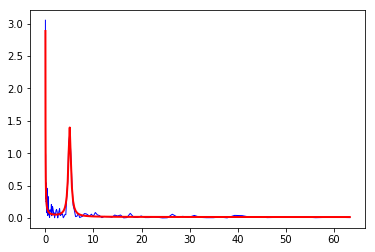

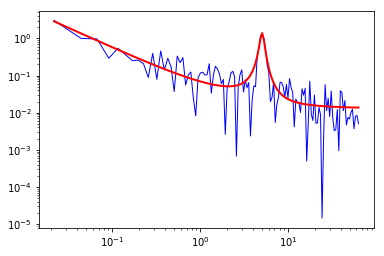

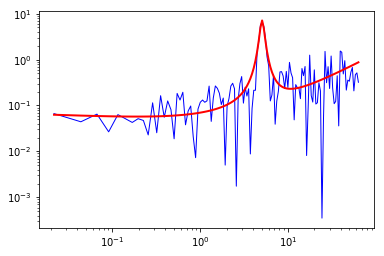

In [12]:
model_to_test = models.Lorentz1D(x_0=5.) + models.PowerLaw1D() + models.Const1D(amplitude=2)
print(model_to_test)

t0 = [1.0, 5.0, 6.6, 1.0, 1.0, 1.0, 2.0]
parest, res = fit_crossspectrum(avg_cs1,model_to_test,t0)

print(res.model.parameters)
print(t0)
# SLSQP, TNC, BFGS, CG, Nelder-Mead

# plotting
n = len(avg_cs1.freq)
range_start, range_stop = int(0 * n / 64), int(64 * n / 64) # [range_start:range_stop]

plt.figure()
plt.plot(avg_cs1.freq, np.abs(avg_cs1.power), lw=1, color='blue')
plt.plot(avg_cs1.freq, np.abs(res.mfit), lw=2, color="red")

plt.figure()
plt.loglog(avg_cs1.freq, np.abs(avg_cs1.power), lw=1, color='blue')
plt.loglog(avg_cs1.freq, np.abs(res.mfit), lw=2, color="red")

plt.figure()
plt.loglog(avg_cs1.freq, avg_cs1.freq*np.abs(avg_cs1.power), lw=1, color='blue')
plt.loglog(avg_cs1.freq, avg_cs1.freq*np.abs(res.mfit), lw=2, color="red")

### Model Components

In [13]:
from astropy.modeling import Fittable1DModel, Parameter

In [14]:
class Window1D():
    def __init__(self, model):
        self.model = model
        self.x_0 = model[0].x_0
        self.fwhm = model[0].fwhm

    def __call__(self, x):
        y = np.zeros((len(x),), dtype=np.float)
        for i in range(len(x)):
            if np.abs(x[i] - self.x_0[0]) <= self.fwhm[0]/2:
                y[i] = 1.
        return y

class Optimal1D():
    def __init__(self, model):
        self.model = model
        qpo_component_model = self.model[0]
        all_components_model = self.model
        self.filter = qpo_component_model / all_components_model

    def __call__(self, x):
        return self.filter(x)

In [15]:
result_model = res.model
# Optimal
optimal_filter = Optimal1D(result_model)(avg_cs1.freq)
filtered_abg_cs1_o = optimal_filter*np.abs(avg_cs1.power)
# Window
window_filter = Window1D(result_model)(avg_cs1.freq)
filtered_abg_cs1_w = window_filter*np.abs(avg_cs1.power)

In [16]:
(result_model | Optimal1D(result_model).filter)(avg_cs1.freq)

array([3.94089620e-05, 1.85007636e-04, 5.04579852e-04, 1.11654501e-03,
       2.23757339e-03, 4.28770888e-03, 8.14298528e-03, 1.58084392e-02,
       3.24487850e-02, 7.34163566e-02, 1.89333212e-01, 4.20544792e-01,
       2.97460480e-01, 1.53503047e-01, 9.31858002e-02, 6.41726505e-02,
       4.80864067e-02, 3.82022481e-02, 3.16540890e-02, 2.70625824e-02,
       2.36983211e-02, 2.11458331e-02, 1.91538863e-02, 1.75629433e-02,
       1.62674864e-02, 1.51952906e-02, 1.42954516e-02, 1.35311762e-02,
       1.28752817e-02, 1.23072973e-02, 1.18115450e-02, 1.13758378e-02,
       1.09905775e-02, 1.06481178e-02, 1.03423063e-02, 1.00681515e-02,
       9.82157673e-03, 9.59923752e-03, 9.39838545e-03, 9.21676700e-03,
       9.05255019e-03, 8.90427412e-03, 8.77081947e-03, 8.65139985e-03,
       8.54557719e-03, 8.45330836e-03, 8.37503668e-03, 8.31185370e-03,
       8.26577828e-03, 8.24024182e-03, 8.24095630e-03, 8.27753128e-03,
       8.36664493e-03, 8.53865152e-03, 8.85229692e-03, 9.42952356e-03,
      

/Users/swapsha96/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


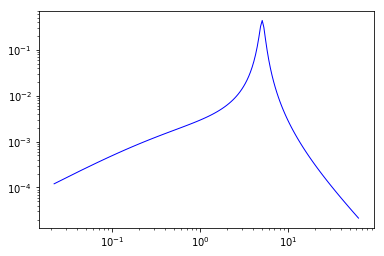

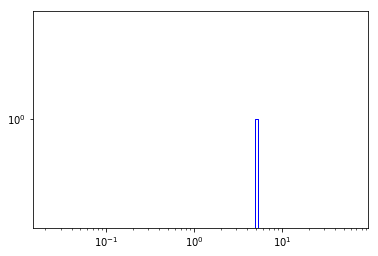

In [17]:
plt.figure()
plt.loglog(avg_cs1.freq, optimal_filter, lw=1, color='blue')

plt.figure()
plt.loglog(avg_cs1.freq, window_filter, lw=1, color='blue')

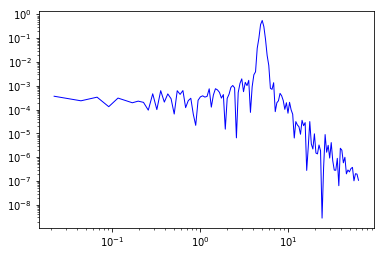

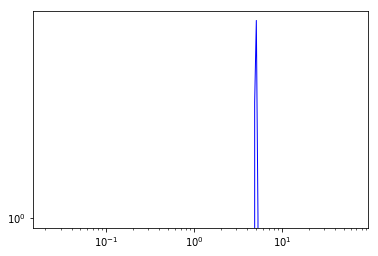

In [18]:
plt.figure()
plt.loglog(avg_cs1.freq, filtered_abg_cs1_o, lw=1, color='blue')

plt.figure()
plt.loglog(avg_cs1.freq, filtered_abg_cs1_w, lw=1, color='blue')

## Calculating CCF

In [19]:
from scipy.fftpack import ifft

### Fitting reference band

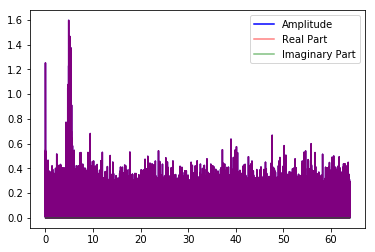

In [20]:
avg_ps = Powerspectrum(lc, norm='abs')
avg_ps.plot()

In [21]:
p_freq = avg_ps.freq # Positive Fourier frequencies
print("Old df: %.4f Hz" % (p_freq[1]-p_freq[0]))
lin_psd, f_bin_edges, something = binned_statistic(p_freq, avg_ps.power[0:int(avg_ps.n/2+1)], 
                            statistic='mean', bins=1600)
new_df = np.median(np.diff(f_bin_edges))
print("New df: %.2f Hz" % new_df)
lin_pfreq = f_bin_edges[0:-1]+0.5*new_df  # so that the frequency is mid-bin

Old df: 0.0003 Hz
New df: 0.04 Hz


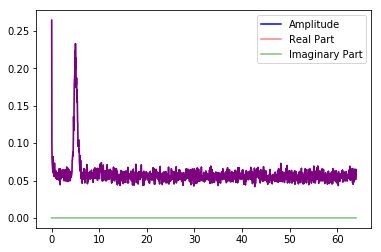

In [22]:
avg_ps_rebin = avg_ps.rebin(df=new_df)
avg_ps_rebin.plot()

Model: CompoundModel8
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Lorentz1D(amplitude=1., x_0=5., fwhm=1.)>

    [1]: <PowerLaw1D(amplitude=1., x_0=1., alpha=1.)>

    [2]: <Const1D(amplitude=2.)>
Parameters:
    amplitude_0 x_0_0 fwhm_0 amplitude_1 x_0_1 alpha_1 amplitude_2
    ----------- ----- ------ ----------- ----- ------- -----------
            1.0   5.0    1.0         1.0   1.0     1.0         2.0


/Users/swapsha96/miniconda3/lib/python3.6/site-packages/astropy-3.1.dev21975-py3.6-macosx-10.7-x86_64.egg/astropy/modeling/powerlaws.py:53: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/swapsha96/miniconda3/lib/python3.6/site-packages/astropy-3.1.dev21975-py3.6-macosx-10.7-x86_64.egg/astropy/modeling/powerlaws.py:53: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/swapsha96/miniconda3/lib/python3.6/site-packages/astropy-3.1.dev21975-py3.6-macosx-10.7-x86_64.egg/astropy/modeling/powerlaws.py:53: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/swapsha96/miniconda3/lib/python3.6/site-packages/astropy-3.1.dev21975-py3.6-macosx-10.7-x86_64.egg/astropy/modeling/powerlaws.py:53: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/swapsha96/miniconda3/lib/python3.6/site-packages/astropy-3.1.dev21975-py3.6-macosx-10

/Users/swapsha96/miniconda3/lib/python3.6/site-packages/astropy-3.1.dev21975-py3.6-macosx-10.7-x86_64.egg/astropy/modeling/powerlaws.py:53: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/swapsha96/miniconda3/lib/python3.6/site-packages/astropy-3.1.dev21975-py3.6-macosx-10.7-x86_64.egg/astropy/modeling/powerlaws.py:53: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/swapsha96/miniconda3/lib/python3.6/site-packages/astropy-3.1.dev21975-py3.6-macosx-10.7-x86_64.egg/astropy/modeling/powerlaws.py:53: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/swapsha96/miniconda3/lib/python3.6/site-packages/astropy-3.1.dev21975-py3.6-macosx-10.7-x86_64.egg/astropy/modeling/powerlaws.py:53: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/swapsha96/miniconda3/lib/python3.6/site-packages/astropy-3.1.dev21975-py3.6-macosx-10

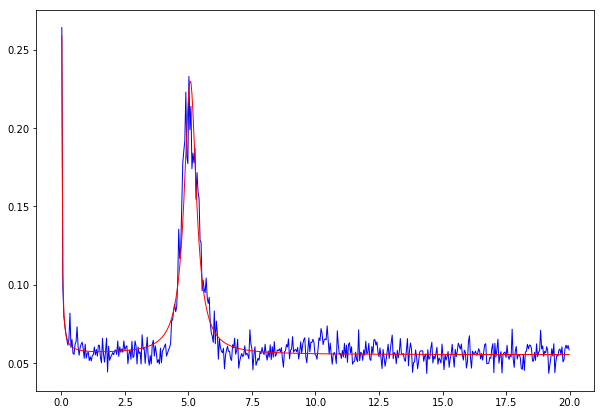

In [23]:
n = len(avg_ps_rebin.freq)
range_start = int(0 * n / 64)
range_stop = int(20 * n / 64)

model_to_test = models.Lorentz1D(x_0=5.) + models.PowerLaw1D() + models.Const1D(amplitude=2)
print(model_to_test)

t0 = [1.0, 5.0, 1.0, 1.0, 1.0, 1.0, 2.0]
parest, ps_res = fit_powerspectrum(avg_ps_rebin, model_to_test, t0)

fig, ax1 = plt.subplots(1,1,figsize=(10,7))
ax1.plot(avg_ps_rebin.freq[range_start:range_stop], avg_ps_rebin.power[range_start:range_stop], lw=1, color='blue')
ax1.plot(avg_ps_rebin.freq[range_start:range_stop], ps_res.model(avg_ps_rebin.freq)[range_start:range_stop], lw=1, color='red')
plt.show()

In [24]:
def get_rms_model(model, freq, optimal_filter=False):
    model_output = model(freq)
    if optimal_filter:                   # optimal filter
        for i in range(len(freq)):
            if freq[i] <= 0:
                model_output[i] = 0
    else:                                # window function
        x_0 = model[0].x_0.value
        fwhm = model[0].fwhm.value
        for i in range(len(freq)):
            if np.abs(freq[i]-x_0) >= (fwhm/2):
                model_output[i] = 0
    return model_output

In [25]:
model = ps_res.model
pos_model = get_rms_model(model, avg_ps_rebin.freq, optimal_filter=True) # Note: Here, `optimal_filter` is set to True
ref_band_rms = np.sqrt(np.sum(pos_model * avg_cs1.df)) # ps = Ref band power spectrum
ref_band_rms

1.4213596834444895

In [26]:
times = np.arange(0, len(filtered_abg_cs1_o)*dt, dt) # filtered avg. cs (using optimal filter)
len(times)

ccf = ifft(filtered_abg_cs1_o)
ccf_real = ccf.real # taking the real part only
ccf_real_norm = ccf_real * (2/n_bins/ref_band_rms) # absolute rms-squared normalisation

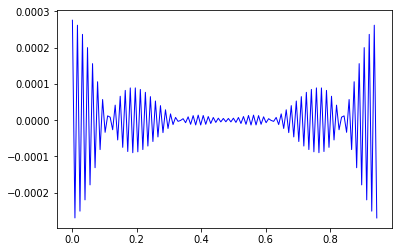

In [27]:
count_rate = ccf_real_norm/dt #here, dt is taken from metadata

plt.figure()
plt.plot(times, count_rate, lw=1, color='blue')

### Using tophat filter

In [28]:
model = ps_res.model
pos_model = get_rms_model(model, avg_ps_rebin.freq, optimal_filter=False) # Note: Here, `optimal_filter` is set to False
ref_band_rms = np.sqrt(np.sum(pos_model * avg_ps_rebin.df)) # ps = Ref band power spectrum
ref_band_rms

0.32976611125144956

In [29]:
times = np.arange(0, len(filtered_abg_cs1_w)*dt, dt) # filtered avg. cs (using window function)
len(times)

ccf = ifft(filtered_abg_cs1_w)
ccf_real = ccf.real # taking the real part only
ccf_real_norm = ccf_real * (2/n_bins/ref_band_rms) # absolute rms-squared normalisation

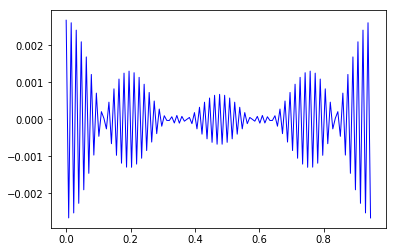

In [30]:
count_rate = ccf_real_norm/dt #here, dt is taken from metadata

plt.figure()
plt.plot(times, count_rate, lw=1, color='blue')